# Import the required packages

In [1]:
from collections import OrderedDict
from glob import glob
from datetime import datetime, timedelta
import string
import os
import itertools
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from matplotlib import ticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
import keras.backend as K

import mlflow
import mlflow.keras
import tensorflow as tf

warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plot_font_dict = {'fontname':'Arial'}

def NRMSE(yhat, y):
    num = np.sqrt(np.mean((yhat.flatten() - y.flatten())**2))
    den = max(y) - min(y)
    return num / den

def k_NRMSE(y_true, y_pred):
    num = K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    num = tf.cast(num, tf.float32)
    
    den = K.max(y) - K.min(y)
    den = tf.cast(den, tf.float32)
    
    return (num / den) * 100

def normalize_data(data, max_bound=1, min_bound=-1):
    return (max_bound - min_bound) * (data - min(data)) / (max(data) - min(data)) + min_bound

Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Raw data

Text(0.5, 0, 'Time (h)')

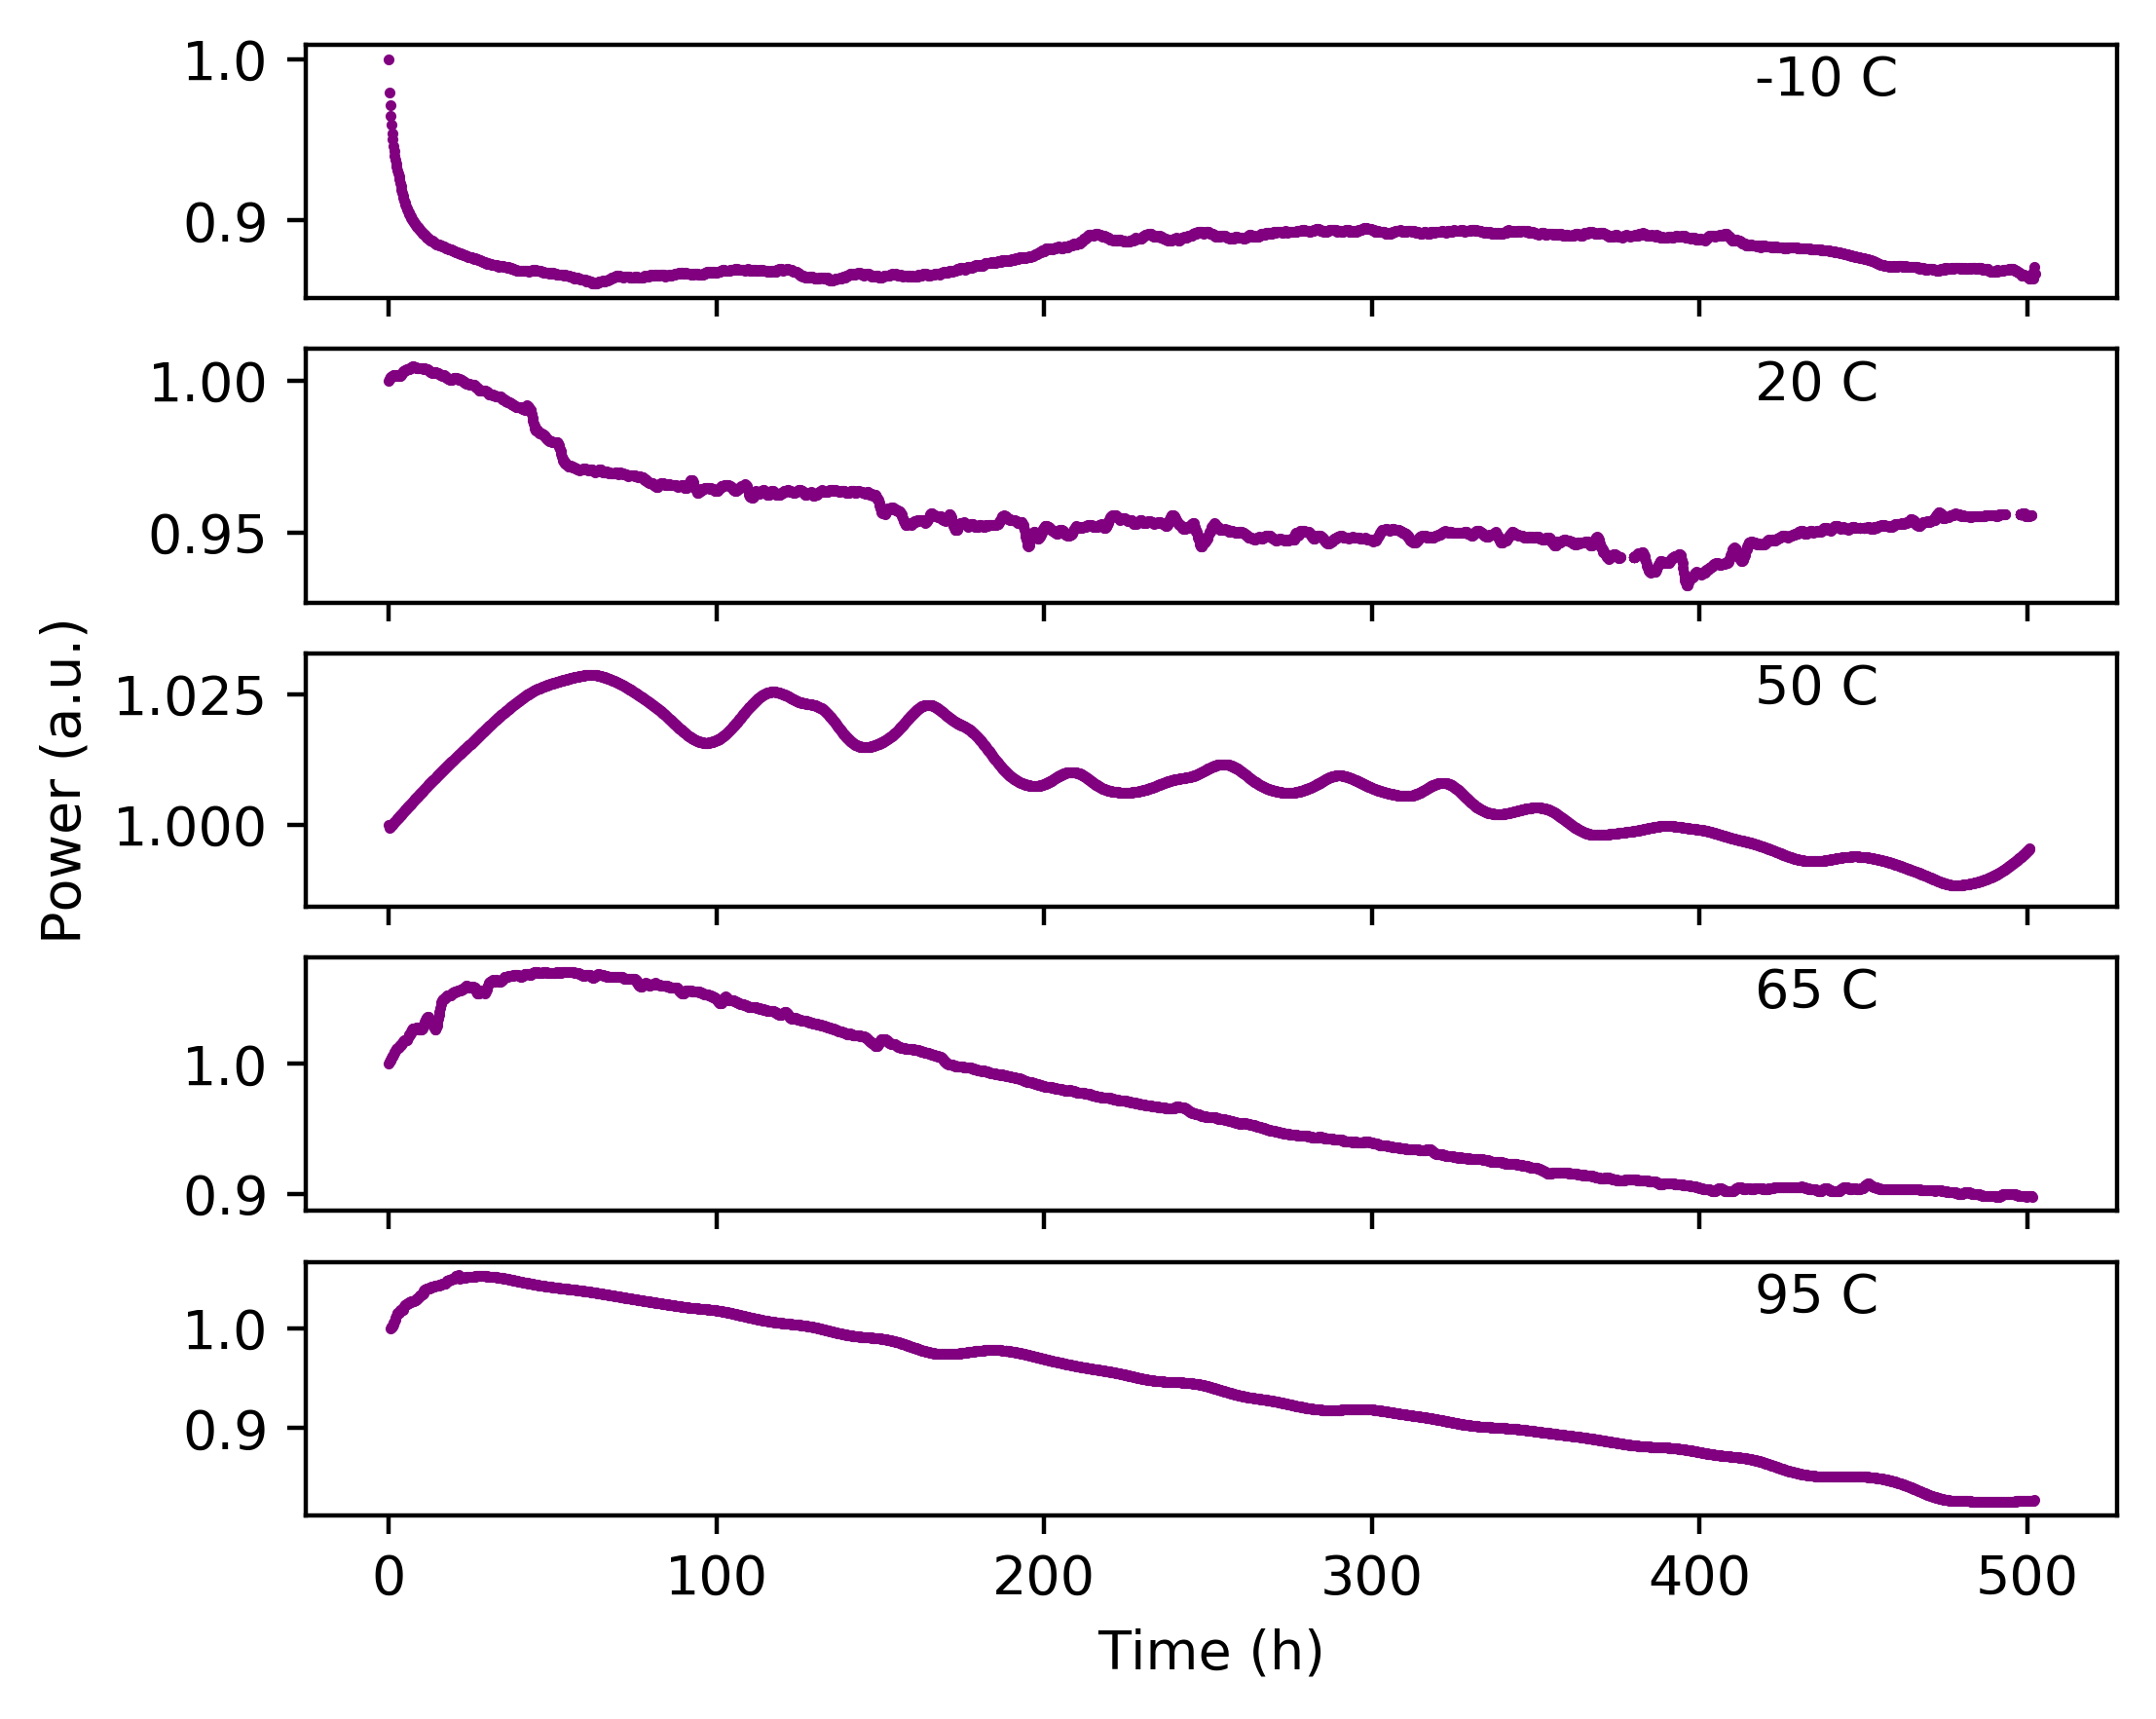

In [3]:
fig, axarr = plt.subplots(5, 1, sharex=True)
axes = axarr.flatten()
fig.dpi = 400
fig.set_size_inches((6, 5))

data_dir = '/.../' # SET FILE PATH HERE
filenum_2_df = {}
temps = [-10, 20, 50, 65, 95]
for file_num, df_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):

    data_df = pd.read_csv(df_fpath, sep='\t', header=0, infer_datetime_format=True)
    data_df.t_delta = pd.to_timedelta(data_df.duration, unit='h')
    data_df = data_df.set_index(data_df.t_delta)
    data_df = data_df.resample('12T').bfill() 
    axes[file_num].scatter(data_df.duration, data_df.power / data_df.power[0], color='purple', s=1)
    
    if file_num == 2:
        axes[file_num].set_ylabel('Power (a.u.)')
        
    axes[file_num].text(0.8, 0.8, '%s C' % temps[file_num], transform=axes[file_num].transAxes)
    
axes[file_num].set_xlabel('Time (h)')

# Data preprocessing

In [4]:
def preprocess_data(data_dir):
    
    data_dfs = []
    for file_num, data_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):
        
        data_df = pd.read_csv(data_fpath, sep='\t', header=0, infer_datetime_format=True)
        data_df.t_delta = pd.to_timedelta(data_df.duration, unit='h')
        data_df = data_df.set_index(data_df.t_delta)
        
        data_df = data_df.resample('60T').bfill() 
        seconds = pd.to_timedelta(data_df.index - data_df.index[0]).astype('timedelta64[s]')
        data_df['duration'] = seconds / 3600
        
        data_df = data_df[data_df.duration >= 0.45]
        data_df = data_df[data_df.duration <= 500]
        data_df.power = data_df.power / data_df.power[0]
        
        if '10C' in data_fpath:
            data_df['temperature']=-10
        elif '20C' in data_fpath:
            data_df['temperature']=20
        elif '50C' in data_fpath:
            data_df['temperature']=50
        elif '65C' in data_fpath:
            data_df['temperature']=65
        elif '95C' in data_fpath:
            data_df['temperature']=95
            
        data_dfs.append(data_df)
    
    return data_dfs

def augment_data_vis(data_df_pairs):
    
    new_pwr_vectors = []
    new_pwr_vectors_lists = []
    
    new_vec_arrays = []
    new_vec_arrays_lists = []
    
    for pair_num, (key, value) in enumerate(data_df_pairs.items()):
        
        (pwr_df_1, pwr_df_2) = value
        num_steps = pwr_df_2.temperature[0] - pwr_df_1.temperature[0]
        pwr_vec_1 = pwr_df_1.power.values
        pwr_vec_2 = pwr_df_2.power.values
        
        temp_vec_1 = pwr_df_1.temperature.values
        temp_vec_2 = pwr_df_2.temperature.values
            
        for weight_num, weight in enumerate(np.linspace(0, 1, num_steps + 1)):
            pwr_vec = weight * (pwr_vec_2 - pwr_vec_1) + pwr_vec_1
            temp_vec = weight * (temp_vec_2 - temp_vec_1) + temp_vec_1
            
            pwr_vec_list = list(np.round(pwr_vec, 4))
            temp_vec_list = list(np.round(temp_vec, 4))

            pwr_temp_vec = np.vstack([pwr_vec, temp_vec])
            
            if pwr_vec_list in new_pwr_vectors_lists:
                continue
            else:
                new_pwr_vectors_lists.append(pwr_vec_list)

                new_vec_arrays.append(pwr_temp_vec)

    return new_vec_arrays

def augment_data_lstm(data_df_pairs):
    
    new_pwr_vectors = []
    new_pwr_vectors_lists = []
    
    new_vec_arrays = []
    new_vec_arrays_lists = []
    
    stacked_vec_array = np.array([])
    
    hold_list = []
    temps = []
    for pair_num, (key, value) in enumerate(data_df_pairs.items()):
        
        (pwr_df_1, pwr_df_2) = value
        num_steps = pwr_df_2.temperature[0] - pwr_df_1.temperature[0]
        pwr_vec_1 = pwr_df_1.power.values
        pwr_vec_2 = pwr_df_2.power.values
        
        temp_vec_1 = pwr_df_1.temperature.values
        temp_vec_2 = pwr_df_2.temperature.values
            
        for weight_num, weight in enumerate(np.linspace(0, 1, num_steps + 1)):
            pwr_vec = weight * (pwr_vec_2 - pwr_vec_1) + pwr_vec_1
            temp_vec = weight * (temp_vec_2 - temp_vec_1) + temp_vec_1
            
            pwr_vec_list = list(np.round(pwr_vec, 4))
            temp_vec_list = list(np.round(temp_vec, 4))

            pwr_vec = pwr_vec.reshape(-1, 1)
            temp_vec = temp_vec.reshape(-1, 1)
            pwr_temp_vec = np.hstack([pwr_vec, temp_vec])
            
            if weight == 0 or weight == 1:
                if temp_vec[0] not in temps:
                    hold_list.append(pwr_temp_vec)
                    temps.append(temp_vec[0])
                continue
                
            if pwr_vec_list in new_pwr_vectors_lists:
                continue
            else:
                new_pwr_vectors_lists.append(pwr_vec_list)

                new_vec_arrays.append(pwr_temp_vec)
                
                
            if stacked_vec_array.size == 0:
                stacked_vec_array = pwr_temp_vec.copy()
            else:
                stacked_vec_array = np.vstack([stacked_vec_array.copy(), pwr_temp_vec.copy()])

    return new_vec_arrays, hold_list

In [5]:
DATA_DIR = '/.../' # SET FILE PATH HERE
data_dfs = preprocess_data(DATA_DIR)
_neg10C, _20C, _50C, _65C, _95C = data_dfs
inter_pairs =OrderedDict()
inter_pairs = {1: (_neg10C, _20C), 2: (_20C, _50C), 3: (_50C, _65C), 4: (_65C, _95C)}
augmented_vects = augment_data_vis(inter_pairs)

Text(0.5, 0, 'Power (norm.)')

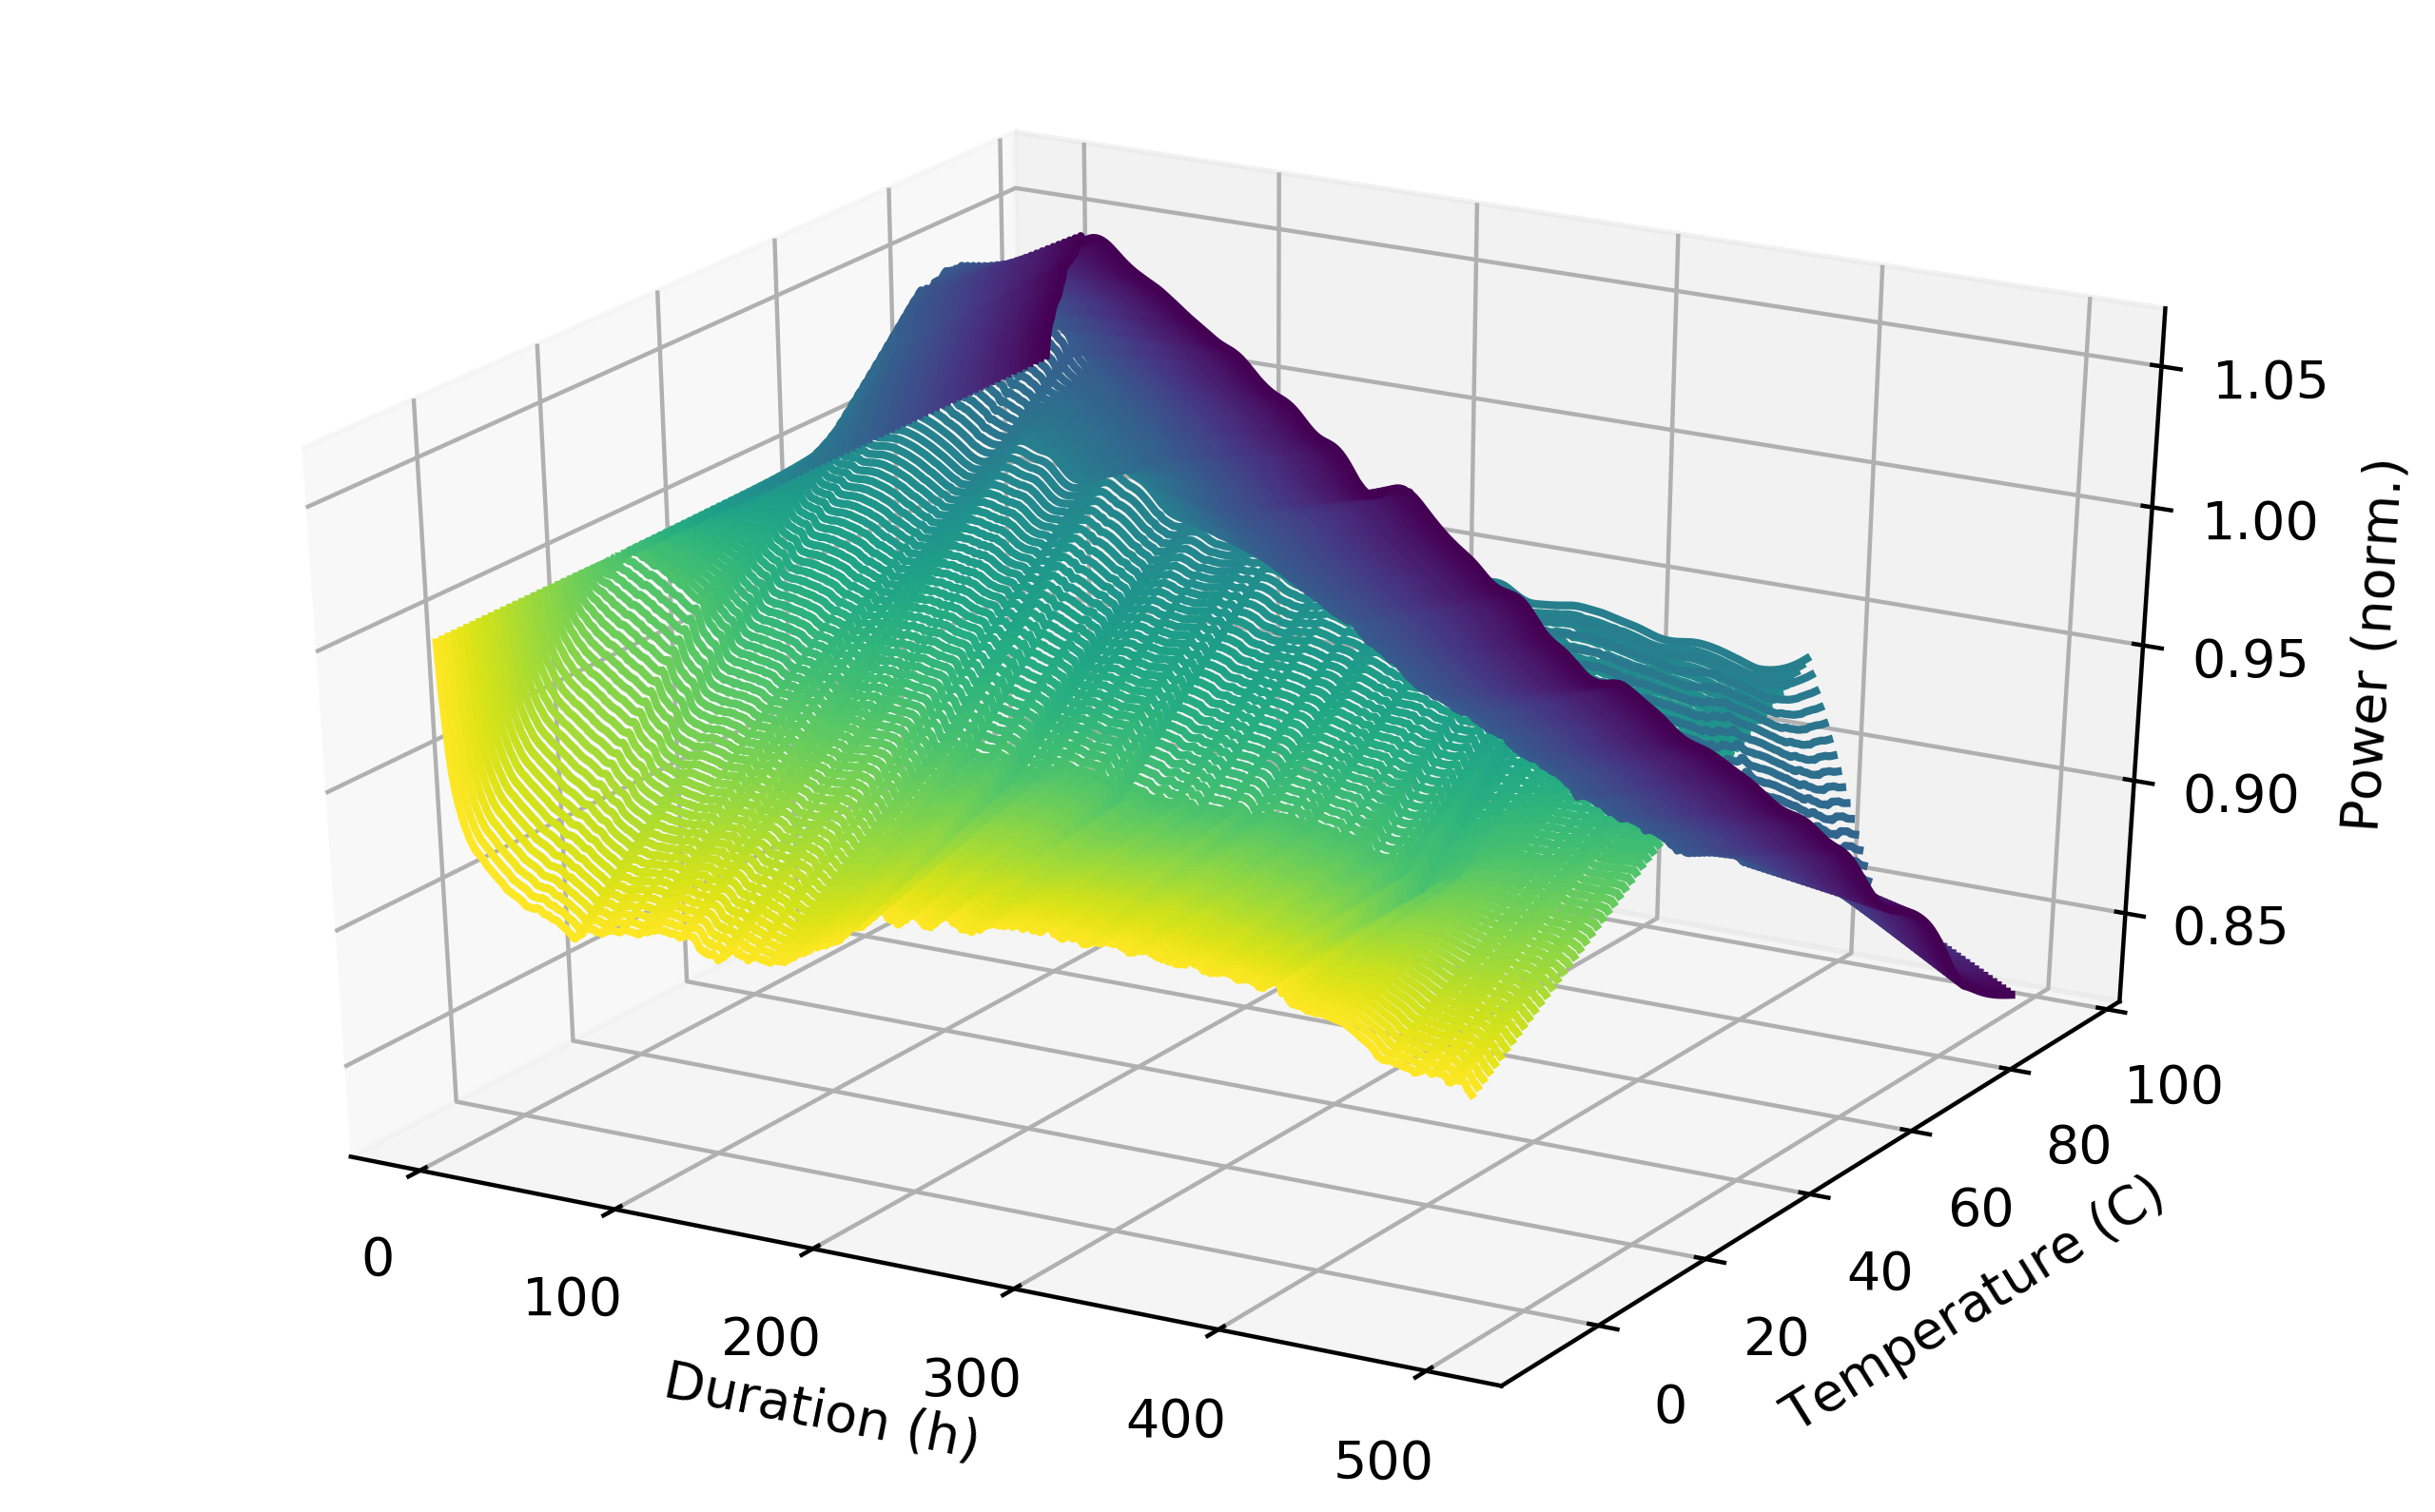

In [6]:
n = len(augmented_vects)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(dpi=400)
fig.set_size_inches(8, 5)
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.viridis_r(np.linspace(0,1,n))

data_resampled = data_df.resample('60T').bfill()
data_resampled = data_resampled[data_resampled.duration >= 0.4]
data_resampled = data_resampled[data_resampled.duration <= 500]
x = data_resampled['duration'].values

for i in range(0, len(augmented_vects)):

    a = augmented_vects[i]
    z = a[0,:]
    y = a[1,:]
    ax.plot(x, y, z, color=colors[i])

ax.set_xlabel('Duration (h)')
ax.set_ylabel('Temperature (C)')
ax.set_zlabel('Power (norm.)')

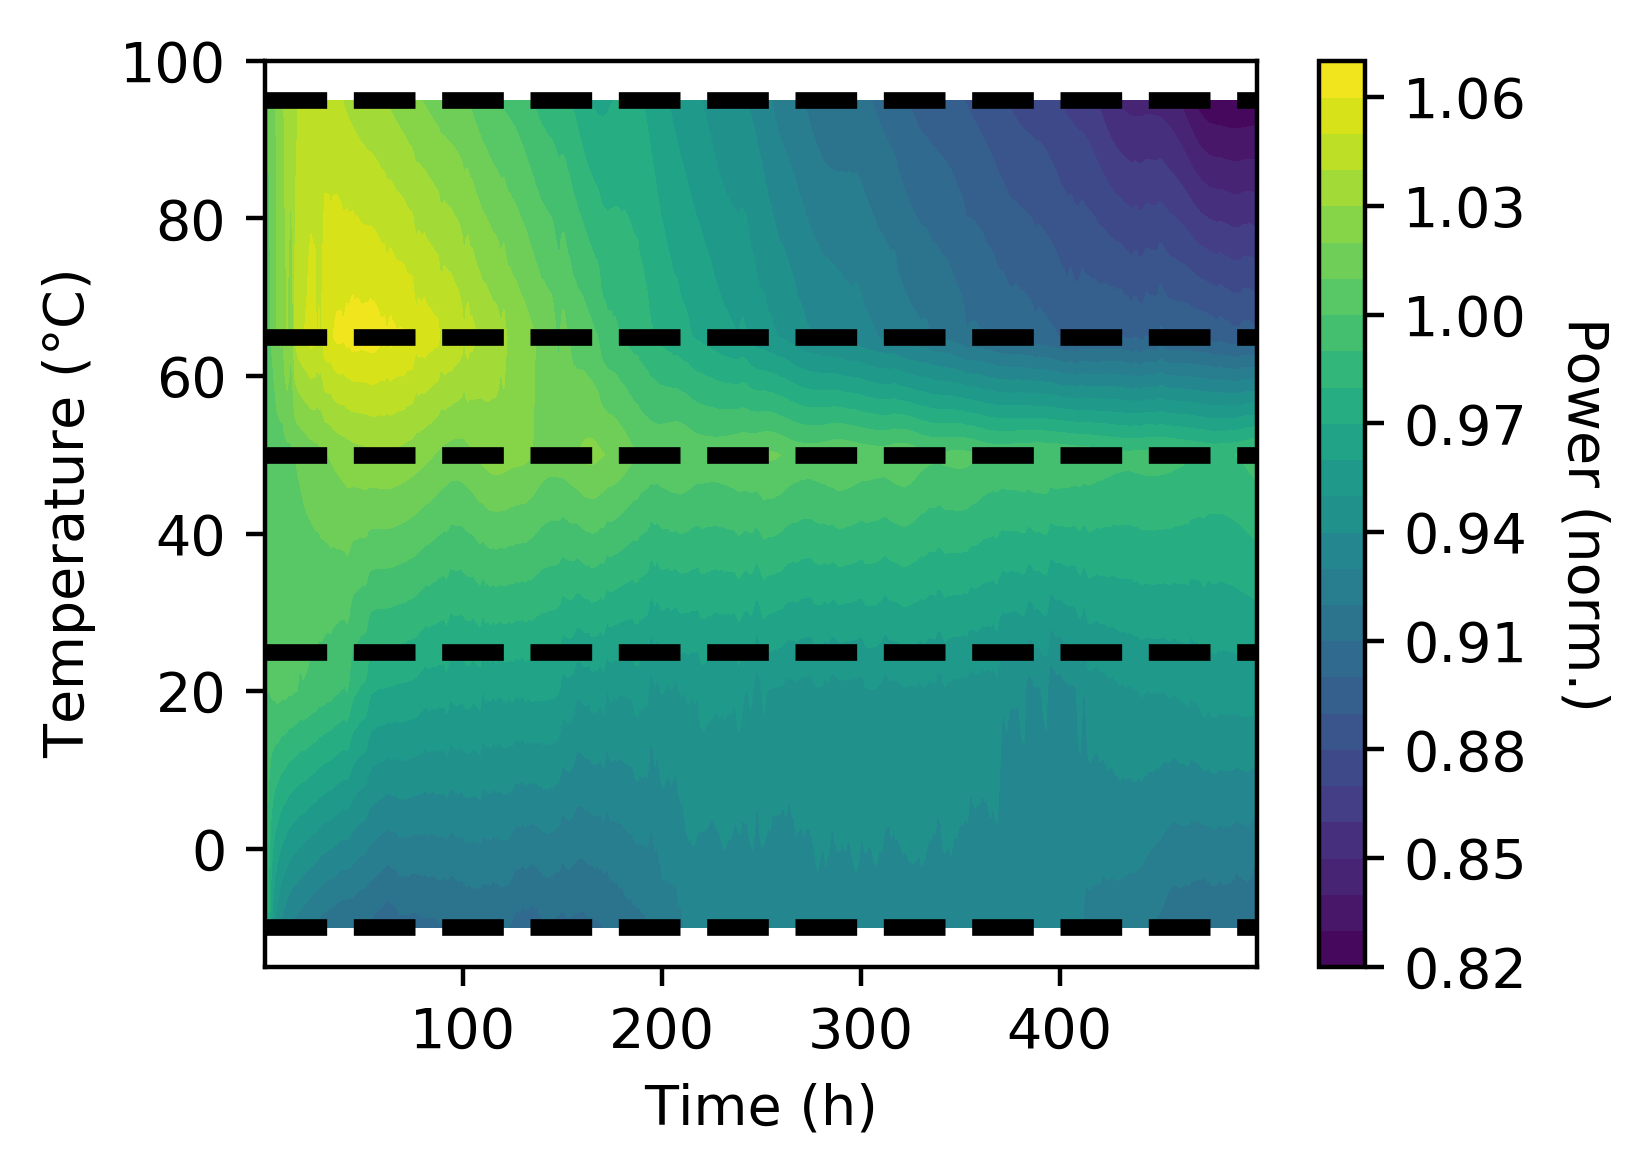

In [7]:
# data preprocessing
augmented_vects_2 = np.array(augmented_vects)
type(augmented_vects_2)
y = augmented_vects_2[:, 1, 0]
x = data_resampled['duration'].values
z = augmented_vects_2[:, 0, :]

fig = plt.figure(dpi=400)
fig.set_size_inches(4, 3)

plt.contourf(x, y, z, levels=25)
plt.xlabel('Time (h)')
plt.ylabel('Temperature ($\degree$C)')
plt.ylim([-15, 100])

cbar = plt.colorbar()
cbar.set_label('Power (norm.)', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

ax = plt.gca()
temps = [-10, 25, 50, 65, 95]
temp_colors = ['#FFFFFF', '#E0E0E0', '#A0A0A0', '#808080', '#202020', ]
for i, (temp, temp_color) in enumerate(zip(temps, temp_colors)):
    ax.axhline(temp, color='black', ls='--', lw=3)

In [8]:
DATA_DIR = '/.../' # SET FILE PATH HERE
data_dfs = preprocess_data(DATA_DIR)
_neg10C, _20C, _50C, _65C, _95C = data_dfs
inter_pairs =OrderedDict()
inter_pairs = {1: (_neg10C, _20C), 2: (_20C, _50C), 3: (_50C, _65C), 4: (_65C, _95C)}
augmented_vects, hold_list = augment_data_lstm(inter_pairs)
augmented_vects_2 = np.array(augmented_vects)
exps = np.array(hold_list)

np.random.seed(1119)
np.random.shuffle(augmented_vects_2)

augmented_vects_2 = np.vstack((augmented_vects_2, exps))
norm_aug_vects = augmented_vects_2.copy()

pwr = norm_aug_vects[:, :, 0].reshape(-1, 1)
temp = norm_aug_vects[:, :, 1].reshape(-1, 1)

pwr_scaler = MinMaxScaler(feature_range=(-1, 1))
temp_scaler = MinMaxScaler(feature_range=(-1, 1))

norm_pwr = pwr_scaler.fit_transform(pwr)
norm_temp = temp_scaler.fit_transform(temp)

aug_vects = np.hstack([pwr, temp])
norm_aug_vects = np.hstack([norm_pwr, norm_temp])

## Split into training and test sets

In [17]:
scaled = norm_aug_vects

# # Create features and label dataset. NOTE: We're predicting a value 24 hours into the future.
# samples_in_cycle = 24

data = scaled[:, [0, 1]] # All of the above columns and remove readings from last 3 cycles
y = scaled[:, 0] # The target/label column and remove readings from first 3 cycles

# Split into train and test sets
# No val set in this case since we are not tuning any hyperparameters
trainX, testX, trainy, testy = train_test_split(data, y, test_size=0.30, random_state=42, shuffle=False)
print(trainX.shape)
print(testX.shape)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 20
batch_size = 500
train_generator = TimeseriesGenerator(trainX, trainy, length=timesteps, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(testX, testy, length=timesteps, sampling_rate=1, batch_size=batch_size)

train_X, train_y = train_generator[0]
print(train_X.shape)
test_X, test_y = test_generator[0]
print(test_X.shape)

train_samples = train_X.shape[0]*len(train_generator)
test_samples = test_X.shape[0]*len(test_generator)

print("Total Records (n): {}".format(data.shape[0]))
print("Total Records after adjusting for 24 hours: {}".format(len(data)))
print("Number of samples in training set (.8 * n): trainX = {}".format(trainX.shape[0]))
print("Number of samples in testing set (.3 * n): testX = {}".format(testX.shape[0]))
print("Size of individual batches: {}".format(test_X.shape[1]))
print("Number of total samples in training feature set: {}".format(train_samples))
print("Number of samples in testing feature set: {}".format(test_samples))

(37100, 2)
(15900, 2)
(500, 20, 2)
(500, 20, 2)
Total Records (n): 53000
Total Records after adjusting for 24 hours: 53000
Number of samples in training set (.8 * n): trainX = 37100
Number of samples in testing set (.3 * n): testX = 15900
Size of individual batches: 20
Number of total samples in training feature set: 37500
Number of samples in testing feature set: 16000


Text(0.5, 0, 'Temperature $\\degree$C')

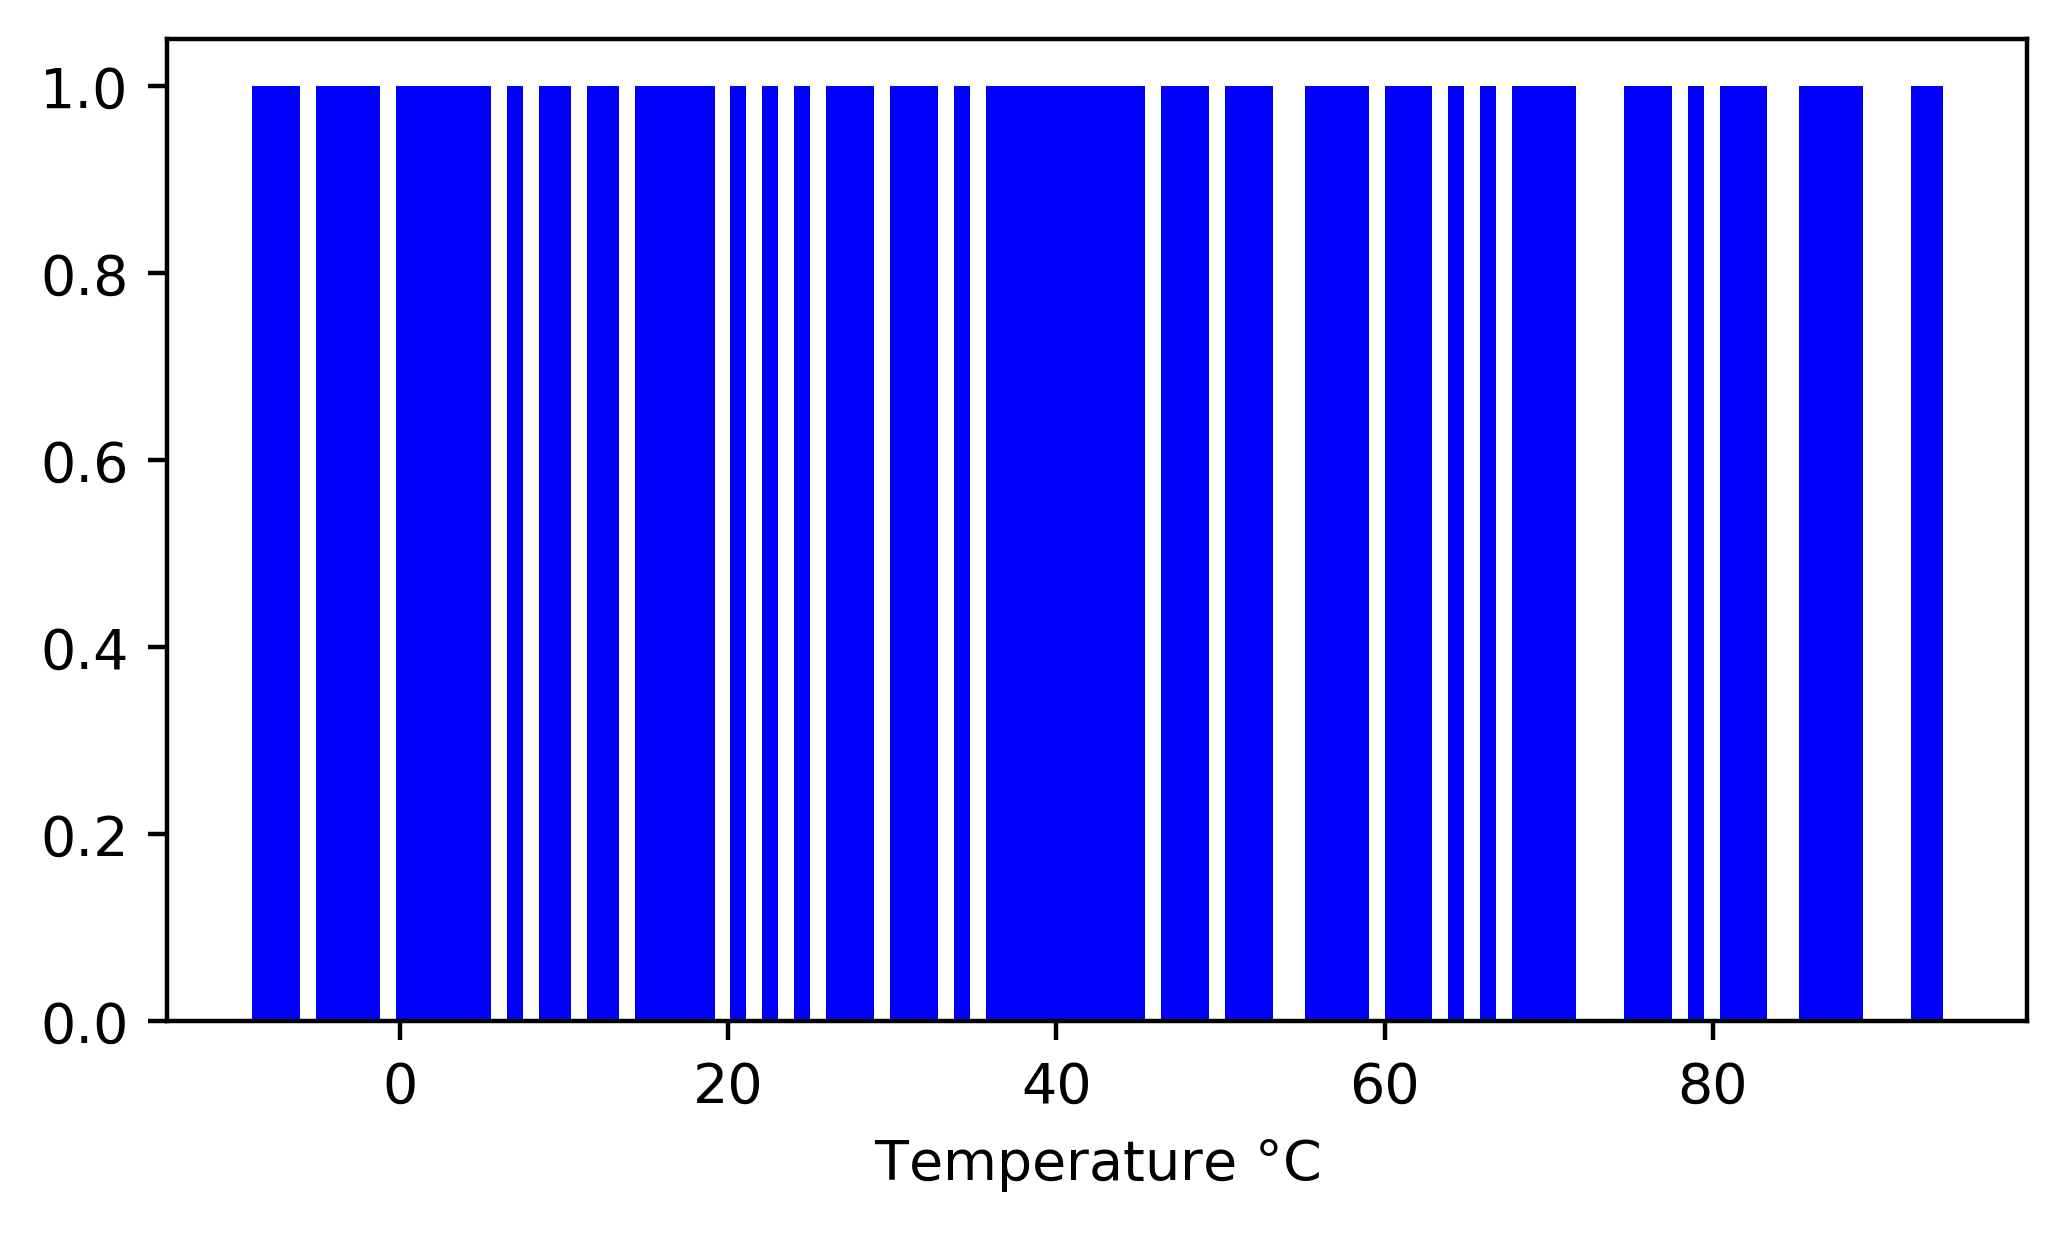

In [10]:
# Visualize train examples
fig = plt.figure()
fig.dpi = 400
fig.set_size_inches((6, 3.25))

train_temps = np.unique(trainX[:, 1])
train_temps = temp_scaler.inverse_transform(train_temps.reshape(-1, 1))

_ = plt.hist(train_temps, 106, color='blue')
plt.xlabel('Temperature $\degree$C')

Text(0.5, 0, 'Temperature $\\degree$C')

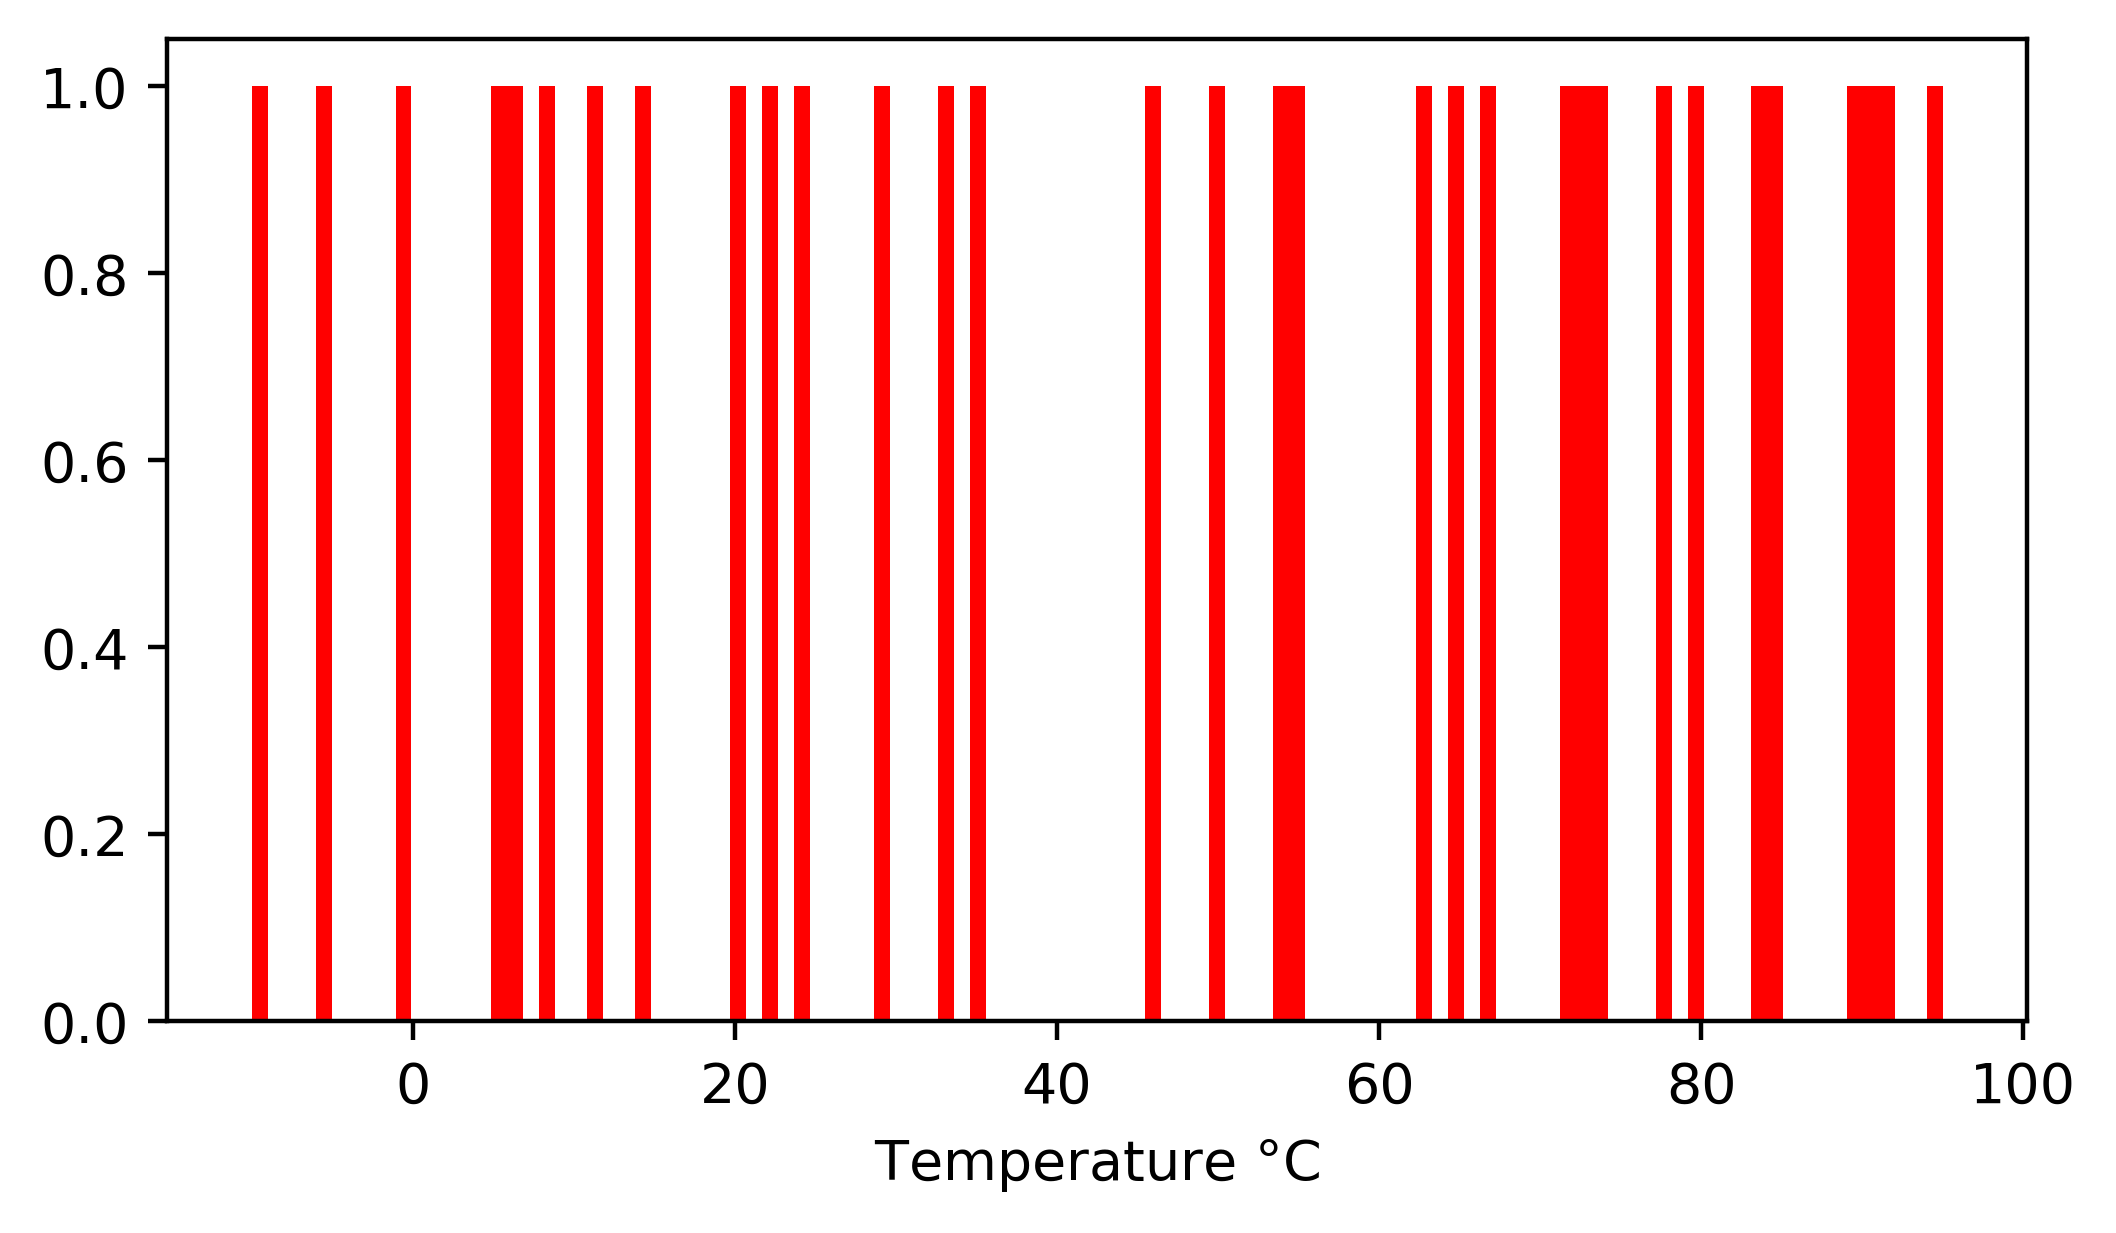

In [11]:
#Visualize test examples
fig = plt.figure()
fig.dpi = 400
fig.set_size_inches((6, 3.25))

test_temps = np.unique(testX[:, 1])
test_temps = temp_scaler.inverse_transform(test_temps.reshape(-1, 1))

_ = plt.hist(test_temps, 106, color='red')
plt.xlabel('Temperature $\degree$C')

# Train the LSTM

In [12]:
# LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. 
# We had defined the time steps as n_lag variable in previous step.  
# Time steps are the past observations that the network will learn from (e.g. backpropagation through time).

# For details on what individual hyperparameters mean, see here: https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L2051

units = 5
num_epoch = 30 # Reduced from 200 to decrease runtime. Feel free to adjust and observe how the training process changes.
learning_rate = 0.00144

with mlflow.start_run(nested=True):

    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LeakyReLU(alpha=0.5)) 
    model.add(Dropout(0.1))
    model.add(Dense(1))

    adam = Adam(lr=learning_rate)
    # Stop training when a monitored quantity has stopped improving.
    callback = [EarlyStopping(monitor="loss", min_delta = 0.00001, patience = 50, mode = 'auto', restore_best_weights=True)]#, tensorboard] 

    # Using regression loss function 'Mean Absolute Percentage Error' and validation metric 'Normalized Root Mean Square Error'
    model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=[k_NRMSE])
    model.summary()
    
    # Fit network
    history = model.fit_generator(train_generator, \
                                  epochs=num_epoch, \
                                  validation_data=test_generator, \
                                  callbacks = callback, \
                                  verbose=2, \
                                  shuffle=False, \
                                  initial_epoch=0)

    mlflow.log_param("Units", units)
    mlflow.log_param("Epochs", num_epoch)
    mlflow.log_param("Learning Rate", learning_rate)
    mlflow.log_param("Lags cosidered", timesteps)

    # Return loss value and metric value
    score = model.evaluate_generator(test_generator, verbose=0)   
    mlflow.log_metric("Test Loss", score[0]) 
    mlflow.log_metric("mape", score[1])   
    mlflow.log_metric("Actual Epochs", len(history.history['loss']))
    mlflow.keras.log_model(model, "LSTM Model")

2021/01/15 14:24:24 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 3s - loss: 184.8770 - k_NRMSE: 12.4967 - val_loss: 102.8360 - val_k_NRMSE: 12.6669
Epoch 2/30
 - 2s - loss: 107.7750 - k_NRMSE: 11.4917 - val_loss: 84.5631 - val_k_NRMSE: 12.0752
Epoch 3/30
 - 2s - loss: 100.2424 - k_NRMSE: 10.9198 - val_lo

In [13]:
min(history.history['val_k_NRMSE'])

3.339181661605835

# Visualize the results

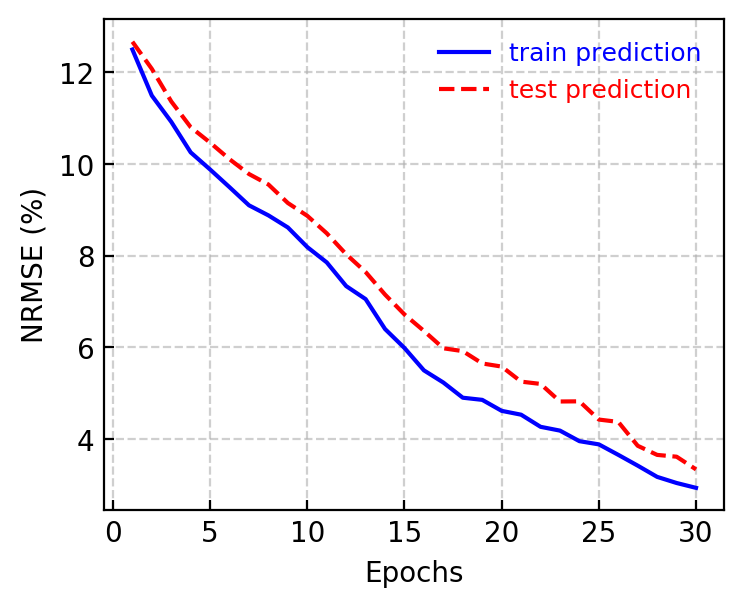

In [14]:
# Plot loss function
fig = plt.figure()
fig.dpi = 200
fig.set_size_inches((4, 3.25))

plt.plot(range(1, len(history.history['k_NRMSE']) + 1), history.history['k_NRMSE'], ls='-', label='train prediction', color='blue')
plt.plot(range(1, len(history.history['val_k_NRMSE']) + 1), history.history['val_k_NRMSE'], ls='--', label='test prediction', color='red')

i=0
leg = plt.legend(frameon=False, fontsize=9)
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    try:
        text.set_color(handle.get_facecolor()[0])
    except AttributeError:
        if i == 0:
            text.set_color('blue')
        else:
            text.set_color('red')
        
    i += 1
        
plt.xlabel('Epochs')
plt.ylabel('NRMSE (%)')

plt.tick_params(axis='both', which='both', direction='in')
ax = plt.gca()

# And a corresponding grid
ax.grid(which='both', ls='--')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.6)
ax.grid(which='major', alpha=0.6)

In [15]:
# Make predictions
yhat_train_temp = model.predict_generator(train_generator)
yhat_test_temp = model.predict_generator(test_generator)

yhat_train = yhat_train_temp[:, 0]
yhat_test = yhat_test_temp[:, 0]

# training results
yhat_train_plot = np.empty(shape=[y.shape[0],])
yhat_train_plot[:] = np.nan
yhat_train.shape = yhat_train.shape[0]
yhat_train_plot.shape = yhat_train_plot.shape[0]
yhat_train_plot[timesteps:len(yhat_train)+timesteps] = yhat_train
  
#test results
yhat_test_plot = np.empty(shape=[y.shape[0],])
yhat_test_plot[:] = np.nan
yhat_test.shape = yhat_test.shape[0]
yhat_test_plot.shape = yhat_test_plot.shape[0]
yhat_test_plot[len(yhat_train)+(timesteps*2):len(y)] = yhat_test

yhat_train_plot = pwr_scaler.inverse_transform(yhat_train_plot.reshape(-1, 1))
yhat_test_plot = pwr_scaler.inverse_transform(yhat_test_plot.reshape(-1, 1))
y = scaled[:, 0]
y = pwr_scaler.inverse_transform(y.reshape(-1, 1))

Temperature: 95 
 NRMSE (%): [14.33059705]
Temperature: 65 
 NRMSE (%): [7.63735577]
Temperature: 50 
 NRMSE (%): [15.89521475]
Temperature: 20 
 NRMSE (%): [8.53914328]
Temperature: -10 
 NRMSE (%): [6.09269459]


Text(0.5, 0, 'Time (h)')

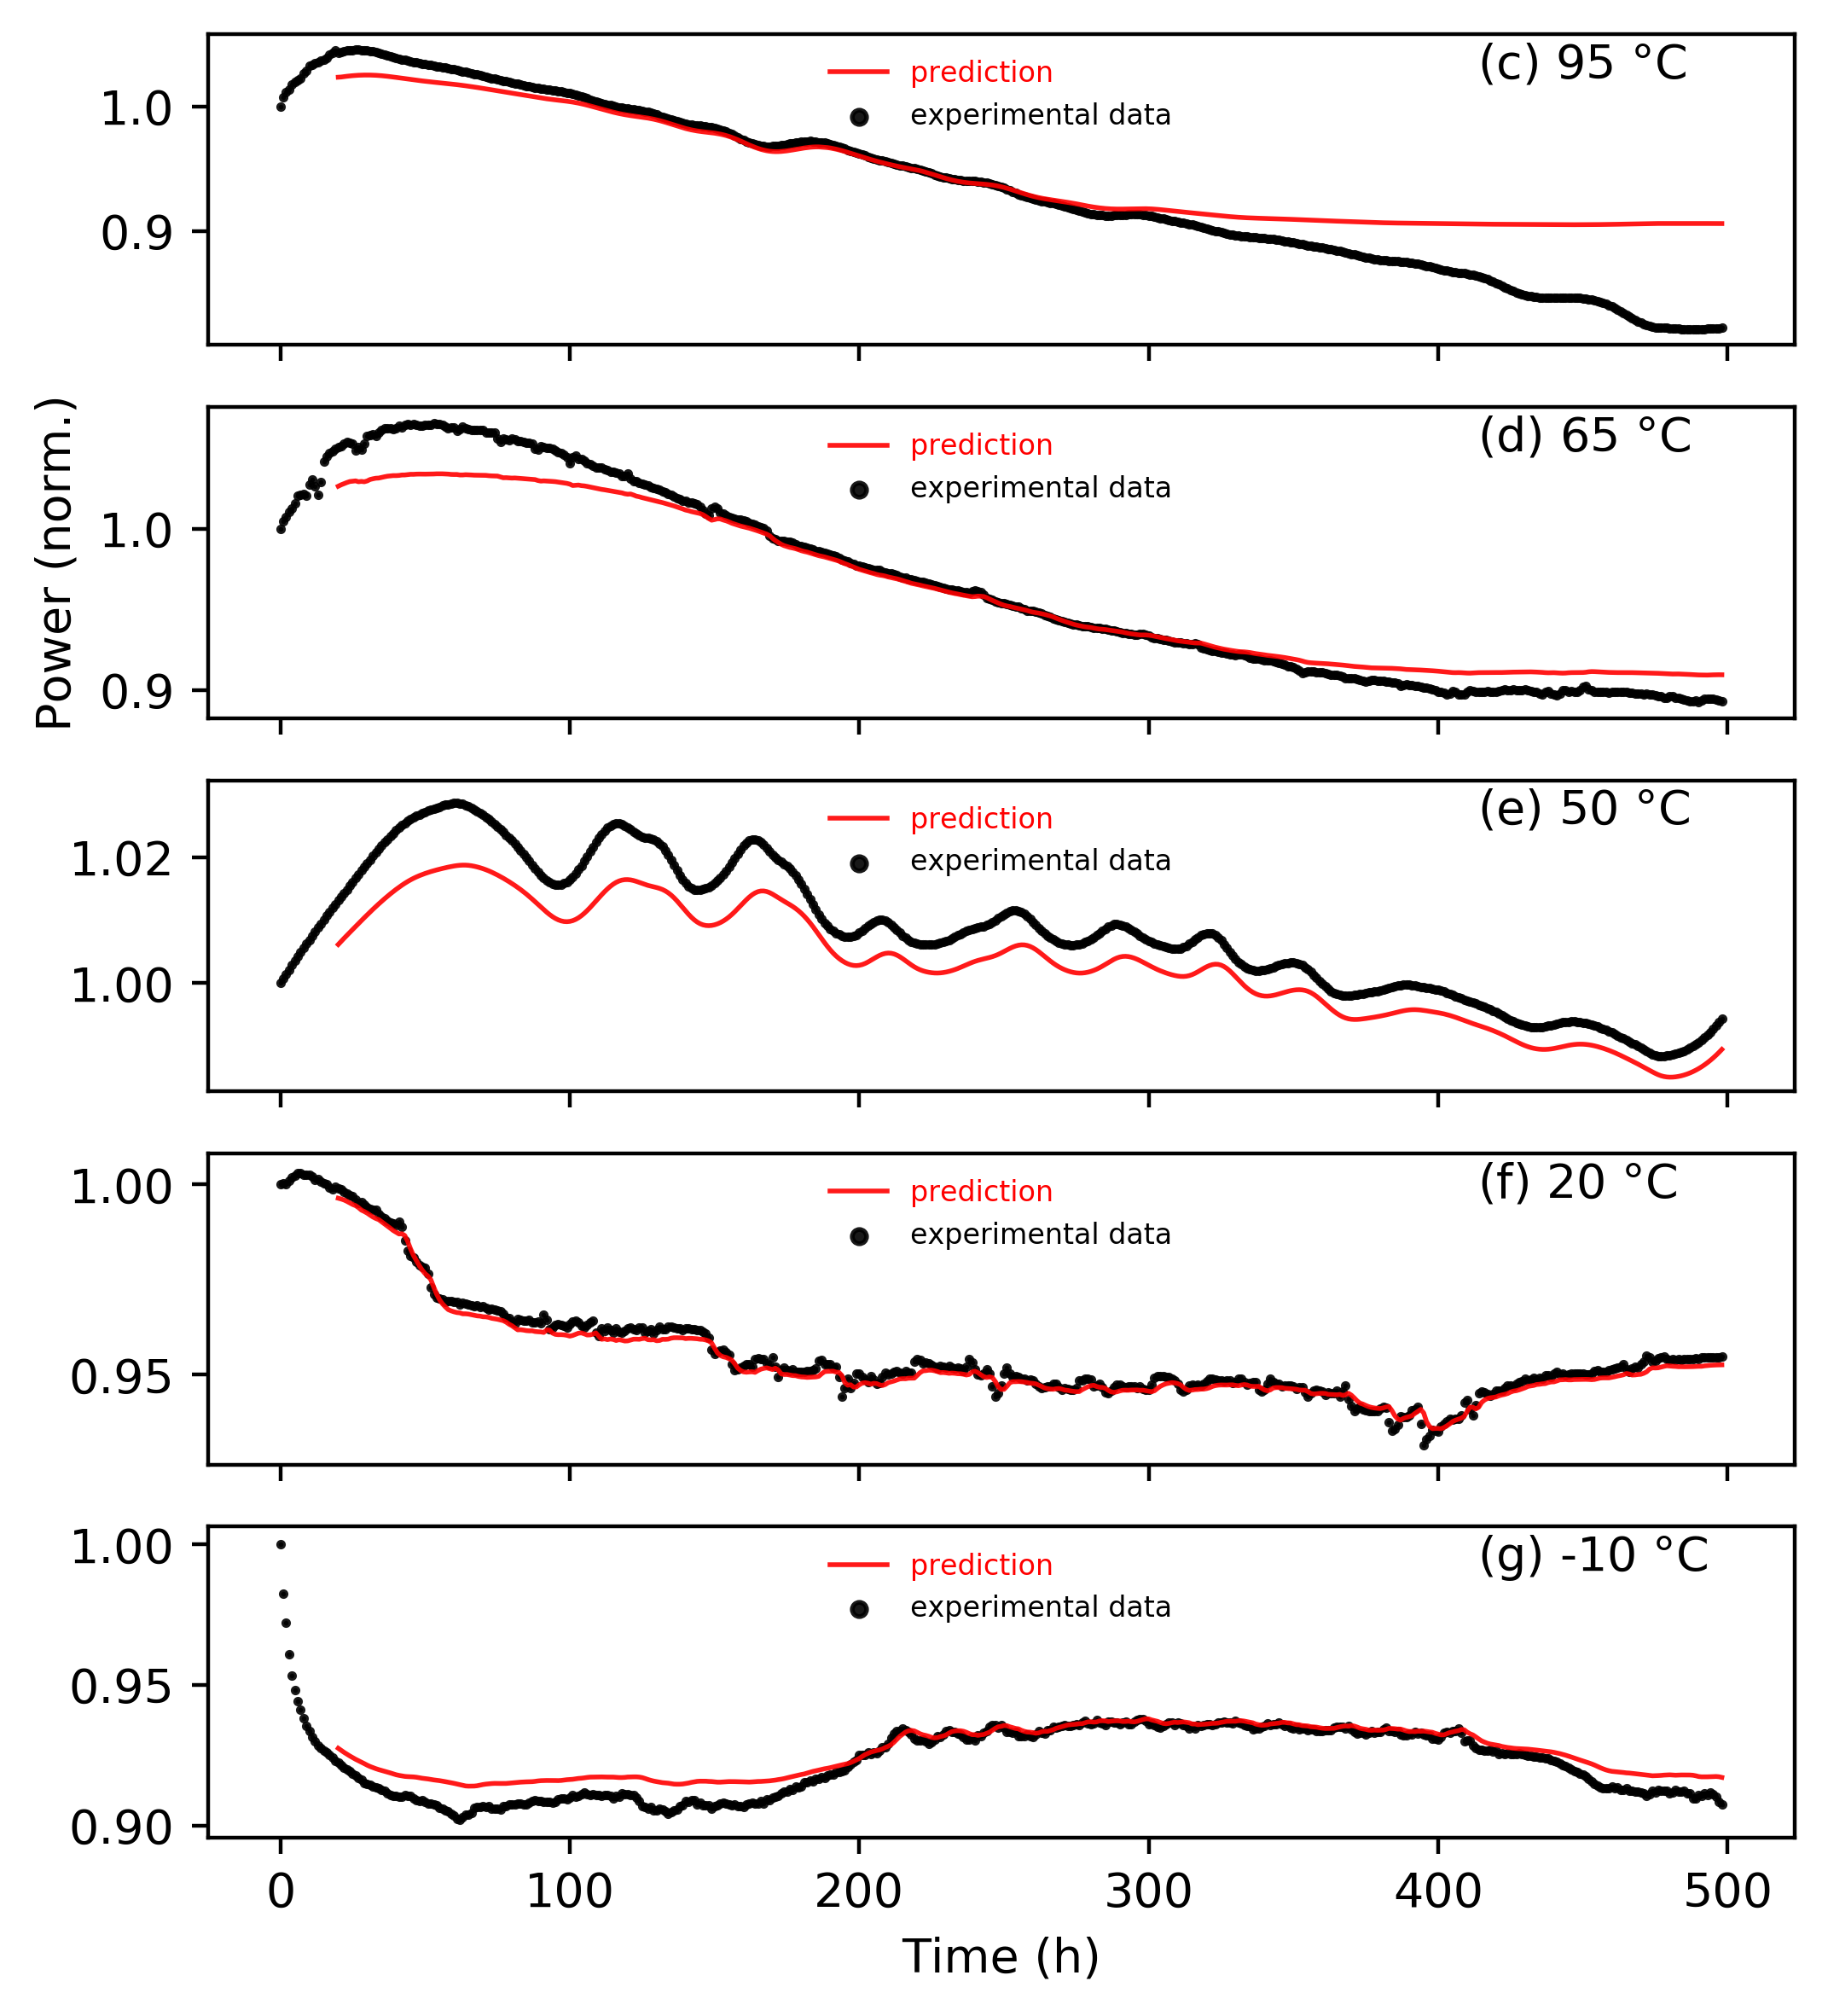

In [16]:
temps = [95, 65, 50, 20, -10]

fig, axarr = plt.subplots(len(temps), 1, sharex=True)
axes = axarr.flatten()
fig.dpi = 400
fig.set_size_inches((6, 7))

for temp_num, temp in enumerate(temps):
    ax = axes[temp_num]
    
    min_bound = np.argwhere(aug_vects[:, 1] == temp)[0][0]
    max_bound = np.argwhere(aug_vects[:, 1] == temp)[-1][0]

    ax.scatter(np.arange(0, len(y[min_bound:max_bound])), y[min_bound:max_bound], s=1, linewidth=1, alpha=0.9, label='experimental data', color='black')
    ax.plot(np.arange(20, len(yhat_test_plot[min_bound:max_bound])), yhat_test_plot[min_bound+20:max_bound], marker='', linewidth=1, alpha=0.9, label='prediction', color='red')

    print('Temperature:', temp, '\n NRMSE (%):', NRMSE(yhat_test_plot[min_bound:max_bound], y[min_bound:max_bound])*100)

    if temp_num==1:
         ax.set_ylabel('Power (norm.)')

    ax.text(0.8, 0.86, '(%s) %s $\degree$C' % (string.ascii_lowercase[temp_num + 2], temp), transform=ax.transAxes)
    
    axes[temp_num].legend(fontsize=8, loc='upper right', frameon=True, markerscale=3)
    handles, labels = axes[temp_num].get_legend_handles_labels()
    
    leg = axes[temp_num].legend(handles, labels, fontsize=6, loc='upper center', frameon=False, shadow=False, framealpha=0.8, markerscale=3)
    
    for line,text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

ax.set_xlabel('Time (h)')